In [169]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
import shap

In [141]:
season_mapping = {
    1: 'Winter', 2: 'Winter', 12: 'Winter', 
    3: 'Spring', 4: 'Spring', 5: 'Spring', 
    6: 'Summer', 7: 'Summer', 8: 'Summer', 
    9: 'Fall', 10: 'Fall', 11: 'Fall'
}

month_mapping = {
    1: 'January', 2: 'February', 3: 'March',
    4: 'April', 5: 'May', 6: 'June',
    7: 'July', 8: 'August', 9: 'September',
    10: 'October', 11: 'November', 12: 'December'
}

---- Feature Importance for Residential sector ----


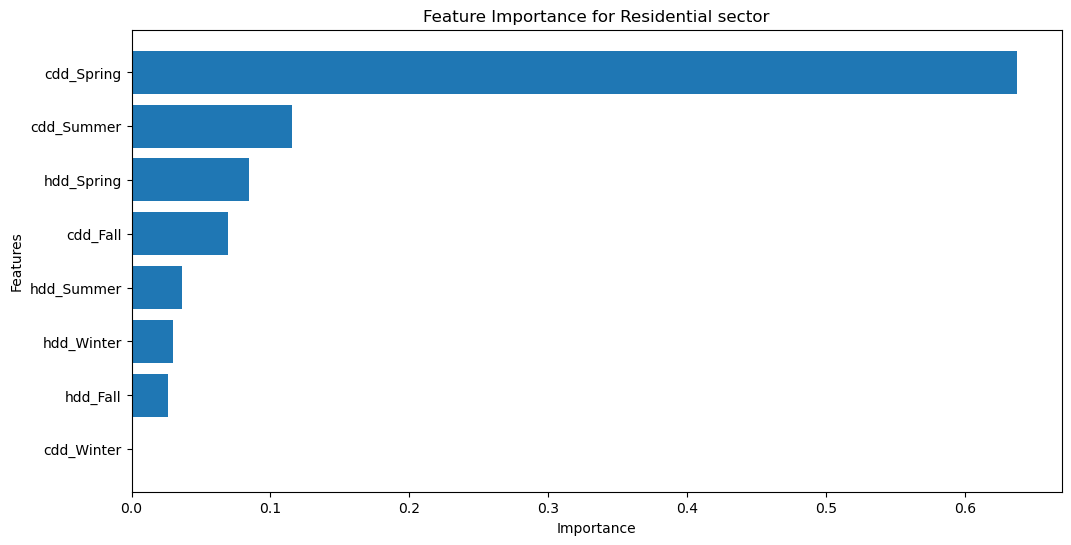

---- Feature Importance for Commercial sector ----


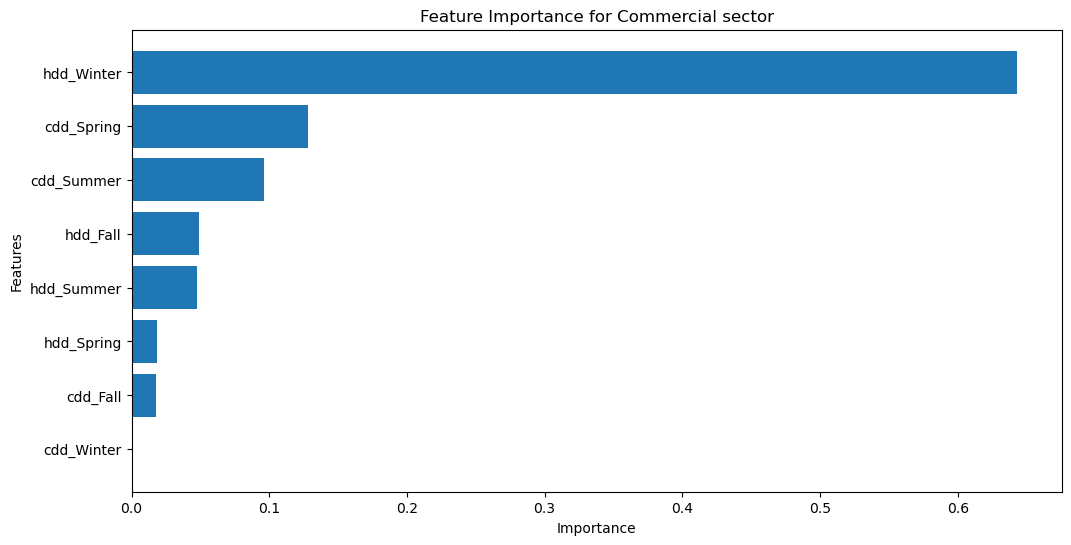

---- Feature Importance for Industrial sector ----


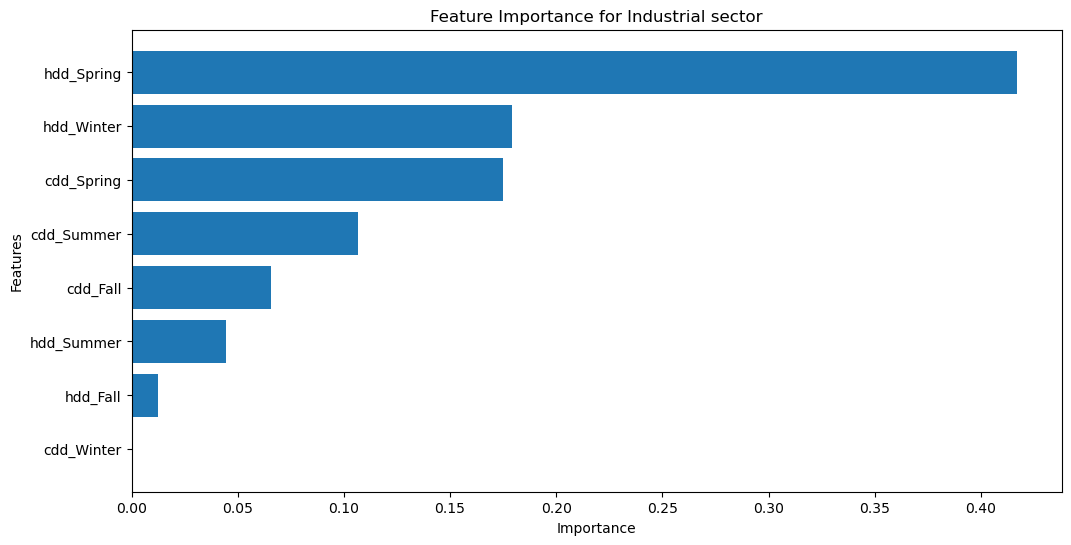

---- Feature Importance for Transportation sector ----


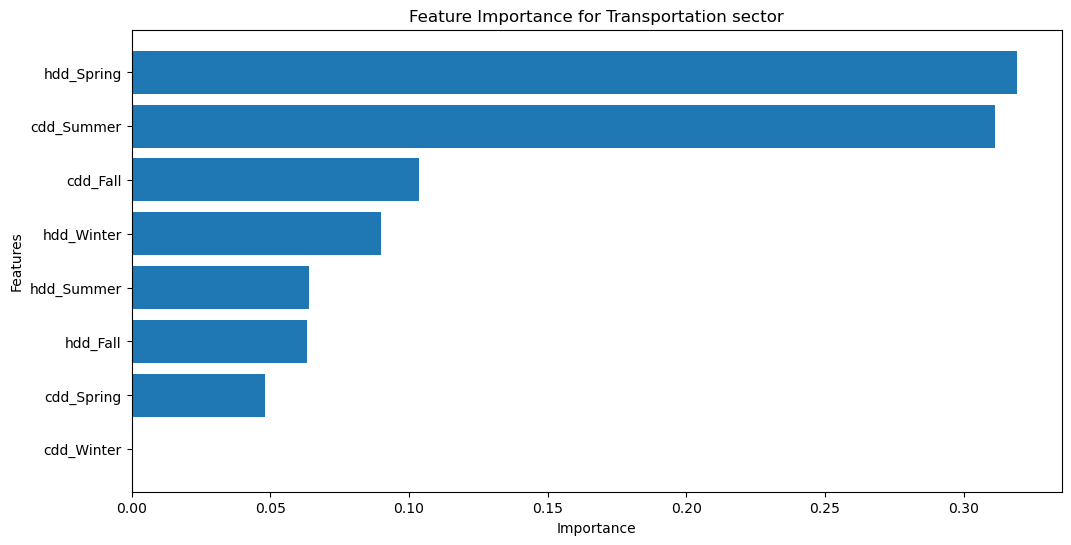

---- Feature Importance for Total consumption ----


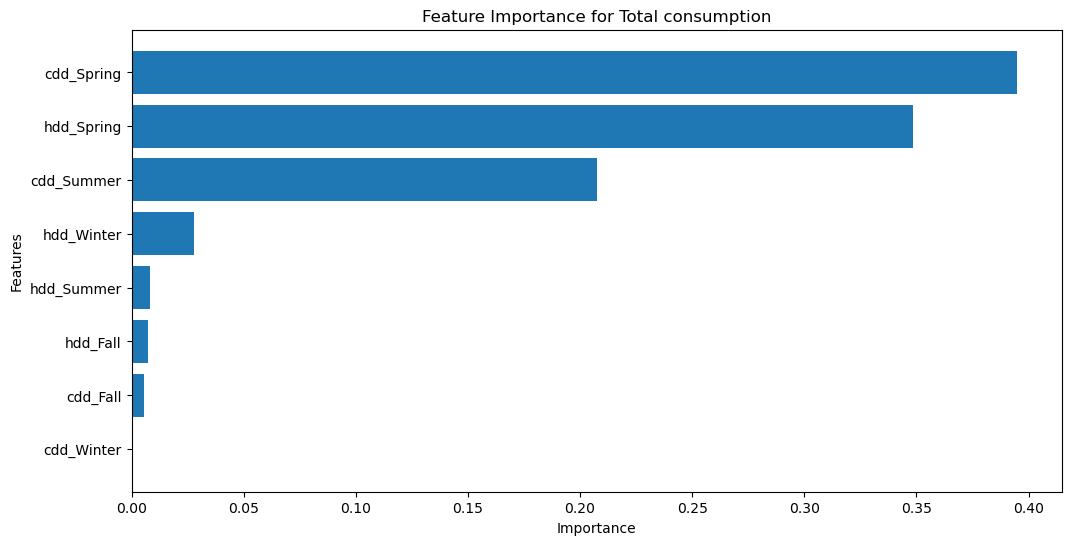

In [179]:
state = 'Michigan'

def create_frame(state):
    weather = pd.read_csv(f'collated_data/{state}.csv')[['Date','cdd','hdd','tavg']]
    weather['Date'] = pd.to_datetime(weather['Date'].astype(str), format='%Y%m')
    weather['Year'] = weather['Date'].dt.year
    # weather['Month'] = weather['Date'].dt.month.map(month_mapping)
    weather['Season'] = weather['Date'].dt.month.map(season_mapping)
    weather_agg = weather.groupby(['Year','Season'])[['cdd', 'hdd']].mean().reset_index()
    # weather_agg['Season_Stat'] = weather_agg.apply(lambda row: row['Season'] + "_" + row['tavg'].__class__.__name__, axis=1)
    weather_pivot = weather_agg.pivot(index='Year', columns='Season', values=['cdd','hdd'])
    weather_pivot.columns = ['_'.join(col).strip() for col in weather_pivot.columns.values]
    energy = pd.read_csv(f'power_consumption/{state}.csv')
    energy.set_index('Year', inplace=True)
    weathergy = pd.concat([weather_pivot, energy[['Residential sector', 'Commercial sector', 
                                                  'Industrial sector', 'Transportation sector', 'Total consumption']]], axis=1)
    return weathergy

weathergy = create_frame(state)

X = weathergy.drop(columns=['Residential sector', 'Commercial sector', 'Industrial sector', 'Transportation sector', 'Total consumption'])
y = weathergy[['Residential sector', 'Commercial sector', 'Industrial sector', 'Transportation sector', 'Total consumption']]

rf = RandomForestRegressor(n_estimators=100, random_state=42)
model = XGBRegressor(random_state=43)

for target_column in y.columns:
    print(f"---- Feature Importance for {target_column} ----")

    # rf.fit(X, y[target_column])
    # rf_feature_importances = rf.feature_importances_

    # model = XGBRegressor(random_state=42)
    model.fit(X, y[target_column])
    feature_importances = model.feature_importances_

    importance_df = pd.DataFrame({
        "Feature": X.columns,
        "Importance": feature_importances
    }).sort_values(by="Importance", ascending=True)

    # features = X.columns
    plt.figure(figsize=(12,6))
    # plt.barh(features, rf_feature_importances)
    plt.barh(importance_df['Feature'], importance_df['Importance'])
    plt.title(f"Feature Importance for {target_column}")
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.show()